# Final State Interaction Via Cascade

## Nuwro Algorithm
1. Take nucleons and pions created in primary vertex
2. Move each particle by the distance of its formation zone???
3. Put all of them into a queue
4. Take a particle from the queue and calculate its mean free path
5. From an exponential distribution, obtain its actual free path
6. Propagate the particle by the distance of its actual free path, but less than some upper threshold
7. Check if it is still in the nucleus
    1. If outside, then particle leaves nucleus
    2. If inside, then was the actual free path greater than the threshold
        1. If yes, add the particle back into the queue
        2. If no, generate the interaction
            1. Check for Pauli blocking for any in the interaction
            2. If no blocking, then add the particles back into the queue
            3. If blocking, veto interaction, and return to previous state

## Josh's Questions
1. Do we need to worry about decays of any of the particles in the cascades?
2. What particles should we consider as possible particles in the cascade? Do we need higher resonance Delta's or Rho's for example?
3. When preforming the cascade, how should we treat the fact that we are moving through a nuclear potential? Should we use something like a Woods-Saxon Potential?

In [1]:
import queue
import numpy as np
import pandas as pd

from scipy.stats import uniform
from scipy import interpolate

from nuChic.FourVector import Vec4
from nuChic.ThreeVector import Vec3
from nuChic.Particle import Particle
from nuChic.Nucleus import Nucleus

# Class that stores all the PDG data table information
from particletools.tables import PYTHIAParticleData
pyth_data = PYTHIAParticleData()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Nuclear Densities

In [3]:
c12Density_db = pd.read_csv('../densities/c12.density',header=10,sep='\s+',names=['r','rho','error'])
c12Density = interpolate.InterpolatedUnivariateSpline(c12Density_db['r'].values,c12Density_db['rho'])

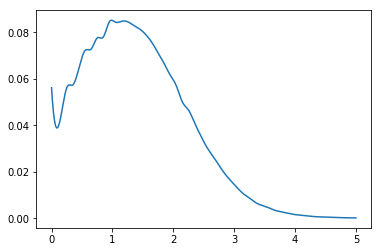

In [4]:
r = np.linspace(0.,5,1000)
rho = c12Density(r)
plt.plot(r,rho)
plt.show()

## Nuclear Potentials

In [5]:
def WoodsSaxon(r,A,V0=50,a=0.5):
    r0 = 1.25
    R = r0*pow(A,1.0/3.0)
    return - V0/(1+np.exp((r-R)/a))

def CoulombPotential(r,Z,A):
    r0 = 1.25
    R = r0*pow(A,1.0/3.0)
    if r <= R:
        return Z*(3*R**2-r**2)/(2*R**3)
    else:
        return Z/r

In [6]:
def R(E,A):
    x = 1000/E
    y = A/(A+20)
    
    
    result = r[0]
    for m in range(1,5):
        print(m)
        result += r[m]*x**m
        
    for n in range(1,3):
        print(n)
        result += r[n+4]*y**n
        
    result += r[8]*x*y
    result += r[9]*x**2*y
    result += r[10]*x*y**2
    
    return pow(A,1.0/3.0)*result

def a(E,A):
    x = 1000/E
    y = A/(A+20)
    
    result = acoeff[0]
    for m in range(1,5):
        print(m)
        result += acoeff[m]*x**m
        
    for n in range(1,3):
        print(n)
        result += acoeff[n+4]*y**n
        
    result += acoeff[8]*x*y
    result += acoeff[9]*x**2*y
    result += acoeff[10]*x*y**2
    return result

def fV(r,E,A):
    return np.cosh(R(E,A)/a(E,A)-1)/(np.cosh(R(E,A)/a(E,A))+np.cosh(r/a(E,A))-2)

def fS(r,E,A):
    return np.cosh(R(E,A)/a(E,A)-1)*(np.cosh(r/a(E,A))-1)/(np.cosh(R(E,A)/a(E,A))+np.cosh(r/a(E,A))-2)**2


In [7]:
R(100,20)

1
2
3
4
1
2


594.0879277081013

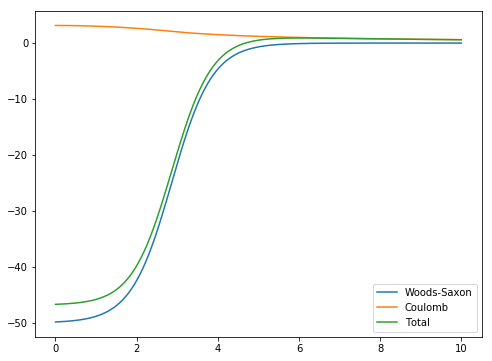

In [8]:
x = np.linspace(0,10,1000)
yW = WoodsSaxon(x,12)
vCoulombPotential = np.vectorize(CoulombPotential)
yC = vCoulombPotential(x,6,12)

plt.figure(figsize=(8,6))
plt.plot(x,yW,label='Woods-Saxon')
plt.plot(x,yC,label='Coulomb')
plt.plot(x,yW+yC,label='Total')
plt.legend()
plt.show()

## Nucleon-Nucleon Cross-Section

In [ ]:
## mN = 0.938

# From GiBUU
def nukNuk_nukNuk(sqrts,massIn,totalcharge):
    if(sqrts>1.338):
        srtf = (sqrts-massIn[0]-massIn[1]+2*mN)**2
        plab = np.sqrt((srtf/(2*mN))**2-srtf)
        if(totalcharge==1): # pn channel
            if(plab<=0.525):
                return 17.0546*mN/(srtf-4*mN**2) - 6.82506
            elif(plab<=0.8):
                return 33. + 196*abs(plab-0.95)**2.5
            elif(plab<=2.0):
                return 31./np.sqrt(plab)
            elif(plab<=2.776):
                return 77./(plab+1.5)
            else:
                return 11.9 + 26.9*plab**(-1.21) + 0.169*np.log(plab)**2 - 1.85*np.log(plab)
        else: # pp or nn channel
            if(plab<=0.435):
                return 5.11775*mN/(srtf-4*mN**2) + 1.67284
            elif(plab<=0.8):
                return 23.5 + 1000*(plab-0.7)**4
            elif(plab<=2.0):
                return 1250/(plab+50) - 4*(plab-1.3)**2
            elif(plab<=2.776):
                return 77/(plab+1.5)
            else:
                return 11.9 + 26.9*plab**(-1.21) + 0.169*np.log(plab)**2 - 1.85*np.log(plab)

# NASA Nucleon-Nucleon 
# https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20080014212.pdf

MeV = 1.0/1000
mb = 1.0
GeV = 1.0

# HZETRN parameters
a = 5.0 * MeV              
b = 0.199/np.sqrt(MeV)     
c = 0.451 * MeV**-0.258      
d = 25.0 * MeV               
e = 134.0 * MeV              
f = 1.187 * MeV**-0.35       
g = 0.1 * MeV                
h = 0.282 * MeV              

# PDG parameters
Zpp  = 33.45 * mb            
Zpn  = 35.80 * mb              
Y1pp = 42.53 * mb              
Y1pn = 40.15 * mb              
Y2pp = 33.34 * mb              
Y2pn = 30.00 * mb              
B    = 0.308 * mb              
s1   = 1.0   * GeV**2           
s0   = (5.38 * GeV)**2 
n1   = 0.458
n2   = 0.545

# JWN parameters
gamma = 52.5 * mb * GeV**(0.16)
alpha = 0.00369 / MeV
beta  = 0.00895741 * MeV**(-0.8)

def sigma_pp(plab):
    Tlab = np.sqrt(plab**2+mN**2)-mN
    if(plab < 1.8):
        if(Tlab >= 0.025):
            return (1+a/Tlab)*(40+109*np.cos(b*np.sqrt(Tlab))*np.exp(-c*(Tlab-d)**(0.258)))
        else:
            return np.exp(6.51*np.exp(-(Tlab/e)**(0.7)))
    elif(plab <= 4.7):
        return gamma/plab**0.16
    else:
        s = 2*mN*(mN+np.sqrt(plab**2+mN**2))
        return Zpp + B*np.log(s/s0)**2 + Y1pp*(s1/s)**n1 - Y2pp*(s1/s)**n2
    
def sigma_np(plab):
    Tlab = np.sqrt(plab**2+mN**2)-mN
    if(plab < 0.5):
        if(Tlab >= 0.1 * MeV):
            return 38 + 12500*np.exp(-f*(Tlab-g)**0.35)
        else:
            return 26000 * np.exp(-(Tlab/h)**0.3)
    elif(plab <= 2.0):
        return 40 + 10*np.cos(alpha*plab - 0.943)*np.exp(-beta*plab**0.8+2)
    else:
        s = 2*mN*(mN+np.sqrt(plab**2+mN**2))
        return Zpn + B*np.log(s/s0)**2 + Y1pn*(s1/s)**n1 - Y2pn*(s1/s)**n2

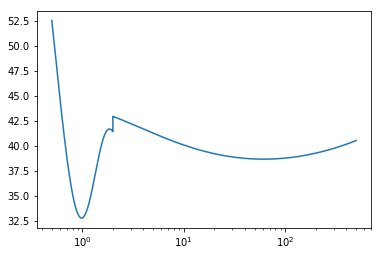

In [10]:
plab = np.logspace(np.log10(0.5),np.log10(500),100000)
sigma = np.zeros_like(plab)
sigma_gibuu = np.zeros_like(plab)
for i,_ in enumerate(plab):
    sigma[i] = sigma_np(plab[i])
    srtf = (sqrts-massIn[0]-massIn[1]+2*mN)**2
    plab = np.sqrt((srtf/(2*mN))**2-srtf)
    sigma_gibuu[i] = nukNuk_nukNuk()
    
plt.plot(plab,sigma)
plt.xscale('log')
plt.show()

## Define the interactions that can occur for a given particle

In [11]:
def PLab(E_inv,mL,mn1):
    arg=(E_inv**2-mL**2-mn1**2)**2/(4.0*mn1**2)-mL**2
    return np.sqrt(arg)

def LN_in_LN(mL,mn1,plab,E_inv):
    plab = PLab(E_inv,mL,mn1)*1e-3
    x=min(2.1,plab_GeV)
    return (39.66-100.45*x+92.44*x**2-21.40*x**3)/plab

def LN_in_SzN(mL,mSz,mn1,mn2,plab,E_inv):
    plab = PLab(E_inv,mL,mn1)*1e-3
    
    pL_CM=np.sqrt(((E_inv**2-mL**2-mn1**2)-4.0*mn1**2*mL**2)/(4.0*E_inv**2))
    pL_CM*=1e-3
    
    pSz_CM=np.sqrt(((E_inv**2-mSz**2-mn2**2)-4.0*mn2**2*mSz**2)/(4.0*E_inv**2))
    pSz_CM*=1e-3
    
    x=min(2.1,plab)
    return (31.1-30.94*x+8.16*x**2)*pSz_CM/pL_CM

def Smp_in_Smp(mSm,mn1,plab,E_inv):
    plab = PLab(E_inv,mSm,mn1)*1e-3
    return 22.4/plab - 1.08

def Spp_in_Spp(mSp,mn1,plab,E_inv):
    plab = Plab(E_inv,mSp,mn1)*1e-3
    return 11.77/plab+19.07

In [12]:
Interaction_Dict = {# Pions (Pi^0, Pi^+)
                    111: [],
                    211: [],
                    # rhos (rho^0, rho^+)
                    113: [],
                    213: [],
                    # eta and eta'
                    221: [],
                    331: [],
                    # Kaons (K_L, K_S, K^+)
                    130: [],
                    310: [],
                    321: [],
                    # D Mesons (D^+, D^0)
                    411: [],
                    421: [],
                    # proton and neutron
                    2212: [[sigma_pp,2212],[sigma_np,2112]],
                    2112: [[sigma_pp,2112],[sigma_np,2212]],
                    # Deltas (Delta^++, Delta^+, Delta^0, Delta^-)
                    2224: [],
                    2214: [],
                    2114: [],
                    1114: [],
                    # Lambda and Simgas (Lamda, Sigma^+, Sigma^0, Sigma^-)
                    3122: [],
                    3222: [],
                    3212: [],
                    3112: [],
                    # Cascades (0,-)
                    3322: [],
                    3312: [],
                    # Charmed Baryons (Lambda_c, Sigma_c^++, Sigma_c^+, Sigma_c^0)
                    4122: [],
                    4222: [],
                    4212: [],
                    4112: [],
                }

## Define interface function to run through the above algorithm

In [287]:
class FSI:
    def __init__(self,nucleus, time_step=1):
        ''' Initialize the FSI class.
    
            Input:
            - nucleus: The definition of the nucleus the interaction occured
                       within. This is defined by the nuclear density.
        '''
        self.nucleus = nucleus
        self.queue = queue.Queue()
        self.time_step = time_step

    def __call__(self,particles):
        ''' This function is the driver for the cascade calculation,
            preforming the selection of the nucleons, and their evolution.
        
            Input: 
            - particles: The nucleons propagating through the nucleus from 
                         initial interaction, defined by their 4-momentums,
                         their positions, and their pids
                         
            Output:
            - escaped: A list of particles that escape the nucleus
        '''
        escaped = []      
        
        # Fill the queue with initial particles
        for particle in particles:
            self.queue.put(particle)
            
        # Main loop over the queue
        while not self.queue.empty():
            particle = self.queue.get()
            prop_dist = particle.propagate(self.time_step)
            
            # Check if particle is still in nucleus
            if particle.r() > self.nucleus.size():
                # Adjust based on potential
                escape = self.nucleus.escape(particle)
                if escape:
                    escaped.append(particle)
                else:
                    self.nucleus.absorb(particle)
                return particle.r()
            else:
                particles_interaction = self.interact(particle)
                if particles_interaction is None:
                    self.queue.put(particle)
                    continue
                if self.pauli_blocking(particles_interaction):
                    # If blocked just veto the interaction and not undo the step
                    #particle.back_propagate()
                    self.queue.put(particle)
                    continue
                if particles_interaction is not None:
                    for particle_int in particles_interaction:
                        self.queue.put(particle_int)
                        return particle_int.r()
        return escaped
                        
    def interact(self,particle):
        # Generate initial momentum for hit particle
        phi = 2*np.pi*np.random.uniform()
        ctheta = 2.0*np.random.uniform()-1.0
        stheta = np.sqrt(1.0-ctheta**2)
        px = self.nucleus.kf * stheta * np.cos(phi)
        py = self.nucleus.kf * stheta * np.sin(phi)
        pz = self.nucleus.kf * ctheta
        E = np.sqrt(1000**2+px**2+py**2+pz**2)
        
        # Calculate all the possible interaction
        sigma = []
        for interaction in Interaction_Dict[particle.pid]:
            plab = particle.mom.P() * MeV
            sigma.append(interaction[0](plab)*1e-1)
            
        sigma_total = sum(sigma)
        prob = sigma_total*self.nucleus.density_P(particle.r())
        prob *= particle.mom.P()/particle.mom.E * self.time_step
            
        # Accept-reject on the interaction
        # Then select interaction based on cross-section
        if np.random.uniform() > prob:
            return None
        
        interaction_index = np.random.choice(len(Interaction_Dict[particle.pid]),p=sigma/sigma_total)
        interaction = Interaction_Dict[particle.pid][interaction_index]
        
        particle_in = Particle(interaction[1],Vec4(E,px,py,pz),particle.pos)
        
        # Boost to center of mass frame
        cm = particle.mom + particle_in.mom
        beta = cm.BoostVector()
        p1_cm = particle.mom.Boost(-beta)
        p2_cm = particle_in.mom.Boost(-beta)
        
        # Generate the final state and return
        phi = 2*np.pi*np.random.uniform()
        ctheta = 2.0*np.random.uniform()-1.0
        stheta = np.sqrt(1.0-ctheta**2)
        px =  p1_cm.P() * stheta * np.cos(phi)
        py =  p1_cm.P() * stheta * np.sin(phi)
        pz =  p1_cm.P() * ctheta
        E_1 = np.sqrt(p1_cm.M2()+px**2+py**2+pz**2)
        E_2 = np.sqrt(p2_cm.M2()+px**2+py**2+pz**2)
        
        particle1_out = Particle(particle.pid, Vec4(E_1,px,py,pz).Boost(beta), particle.pos)
        particle2_out = Particle(particle_in.pid, Vec4(E_2,-px,-py,-pz).Boost(beta), particle_in.pos)
        
        return [particle1_out,particle2_out]
        
    def pauli_blocking(self, particles_interaction):
        # See if Pauli blocking occurs for the proposed interaction
        for particle in particles_interaction:
            if particle.mom.P() < self.nucleus.kf:
                return True
        return False

In [288]:
p = 2000
phi = 2.0*np.pi*np.random.uniform()
costheta = 2.0*np.random.uniform() - 1.0
sintheta = np.sqrt(1.0 - costheta**2)
px = p * sintheta * np.sin(phi)
py = p * sintheta * np.cos(phi)
pz = p * costheta
particle1 = Particle(2112,Vec4(np.sqrt(1000**2+px**2+py**2+pz**2),px,py,pz),Vec3(0,0,0))

In [275]:
particle1.vec

Vec3(0.6184685532851985,0.6114863939003066,-0.20876072109502003)

In [33]:
particle1.pos

Vec3(0,0,0)

In [187]:
dist=particle1.propagate(1e-1)
print(dist)

(0.0005191297358124417,0.005165975429618552,0.0010775888211805801)


In [35]:
particle1.pos

Vec3(0.0006307232292415474,7.095168414451463e-05,0.0005665159932490223)

In [36]:
particle1.back_propagate()

In [37]:
particle1.pos

Vec3(0.0,0.0,0.0)

In [38]:
C12 = Nucleus(6,12,92.15,225,c12Density,c12Density)

In [39]:
C12.size()

2.616119339802647

In [40]:
C12.potential

10.109189638294993

In [273]:
C12.escape(particle1)

False

In [289]:
fsi = FSI(C12)

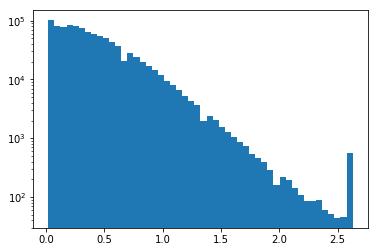

In [291]:
prop_dist = []
nevents = 1000000
for i in range(nevents):
    particle1 = Particle(2112,Vec4(np.sqrt(1000**2+px**2+py**2+pz**2),px,py,pz),Vec3(0,0,0))
    fsi = FSI(C12,1e-1)
    dist = fsi([particle1])
    if dist is not None:
        prop_dist.append(dist)

plt.hist(prop_dist,bins=50)
plt.yscale('log')
plt.show()

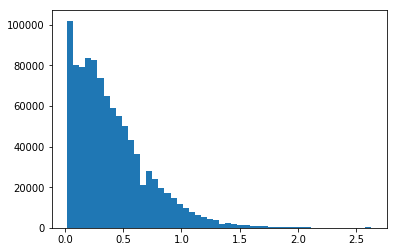

In [292]:
plt.hist(prop_dist,bins=50)
plt.show()